# Traduction Google trad

## Imports

In [94]:
import pandas as pd
import numpy as np
from googletrans import Translator, LANGUAGES
from time import sleep

In [7]:
df = pd.read_csv("../../delphes/data/final2_clean.csv", index_col=0)

In [8]:
df.head()

,mep_id,name,country,group,nat_group,twitter,content
0,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,"['W tym dniu, w tym miejscu, w tej godzinie pr..."
1,189525,Asim ADEMOV,Bulgaria,Group of the European People's Party (Christia...,Citizens for European Development of Bulgaria,AdemovAsim,['RT @ECinBulgaria: 📢 Остана 1⃣ седмица! Преди...
2,124831,Isabella ADINOLFI,Italy,Non-attached Members,Movimento 5 Stelle,Isa_Adinolfi,"[""Sembra un film, ma purtroppo è realtà: le im..."
6,125045,Clara AGUILERA,Spain,Group of the Progressive Alliance of Socialist...,Partido Socialista Obrero Español,ClaraAguilera7,['RT @ClaraAguilera7: Debate e importantes vot...
7,204335,Alviina ALAMETSÄ,Finland,Group of the Greens/European Free Alliance,Vihreä liitto,alviinaalametsa,['Toimeentulotukea korotetaan 75e koronakriisi...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 704
Data columns (total 7 columns):
mep_id       474 non-null int64
name         474 non-null object
country      474 non-null object
group        474 non-null object
nat_group    474 non-null object
twitter      474 non-null object
content      474 non-null object
dtypes: int64(1), object(6)
memory usage: 29.6+ KB


In [26]:
sample = df.content.map(lambda x: x.split(","))

## Create the translator

In [12]:
translator = Translator()

In [109]:
def trad(X):
    res = []
    count = 0
    lan = []
    for i in X:
        lan.append(translator.detect(i).lang)
#         l = translator.detect(i).lang
#         if l in LANGUAGES.keys(): res.append(translator.translate(i, src=l, dest='en').text)
        count +=1
        print(count)
#         sleep(1)
    return lan

In [78]:
trad_content = sample[:2].apply(trad)

pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
sk
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
en
en
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
plcs
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
fi
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
ja
pl
en
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
fr
pl
pl
pl
pl
pl
sk
pl
pl
pl
pl
pl
pl
pl
pl
pt
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
pl
en
pl
pl
pl
en
en
en
pl
en
en
en
pl
en
en
en
en
en
en
en
en
en
en

## Test Translator

In [54]:
translator.translate("представя приоритетите на германското председателство", dest='en').text

'presents the priorities of the German Presidency'

In [65]:
trad = translator.detect("Асим Адемов: ЕС дава 50 млн. евро за еднократни помощи за земеделците с българската мярка Регламент COVID-19")
print(trad.lang)
print(trad.confidence)

bg
1.0


In [111]:
set(trad(sample[1]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


{'bg',
 'bgmk',
 'bgru',
 'bgsr',
 'bguk',
 'en',
 'mk',
 'ru',
 'ruuk',
 'sk',
 'sr',
 'srmk',
 'tl'}

In [91]:
len(sample[1])

441

In [102]:
test = translator.translate(sample[1], dest='en')

In [105]:
for t in test:
    print(t.text)
    print("\n###########\n")

['RT @ECinBulgaria: 📢 1⃣ week left! The advantages of becoming an intern in the EC? \ N \ n📍Online application \ n📍Payed internship \ n📍Multicultural environment \ n📍About… '

###########

'RT @GerbEppBG: - @ AdemovAsim GERB / ​​EPP: Knowing well the situation in the mixed areas

###########

dare I say that

###########

which took place on Rosenets

###########

…'

###########

'Although they appeared uninvited at the GERB meeting and did not behave very decently

###########

I went to the protesters

###########

for… https://t.co/KPft0sJp35 '

###########

'Dr. Daniela Daritkova is a wonderful person and an extremely respected doctor! I'am proud

###########

that he is my friend! \ nCornelia Ninova… https://t.co/JJ2UdwlMMM '

###########

'Today

###########

when a vote of no confidence was taken

###########

Boyko Borissov's government received a vote of confidence not only from MP… https://t.co/oUVXdothbS '

###########

'Asim Ademov: EU gives 50 million euros for one-time a

# Muse

### Exemple

In [2]:
import io
import numpy as np

In [3]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [4]:
src_path = '../../raw_data/vectors_english.txt'
tgt_path = '../../raw_data/vectors_spanish.txt'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [5]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [6]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [7]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6165 - gato
0.5401 - perro
0.4849 - conejo
0.4839 - gorila
0.4746 - felino


In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.06


In [9]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

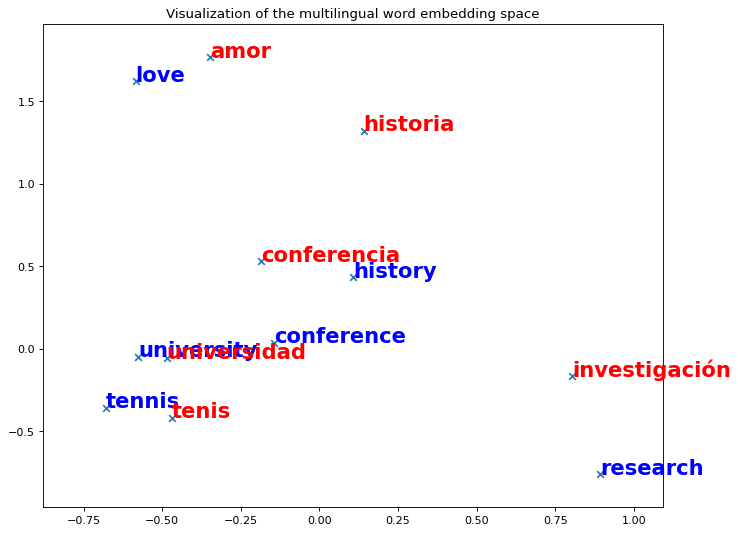

In [10]:
# get 5 random input words
src_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)


### Full Language application

In [71]:
import pandas as pd
import numpy as np
from googletrans import Translator, LANGUAGES
from time import sleep
import string


In [13]:
languages = ["bulgarian", "catalan", "croatian", "czech", "danish", "dutch", "english", "estonian", 
              "finnish", "french", "german", "greek", "hungarian", "italian", "macedonian", "norwegian", 
              "polish", "portuguese", "romanian", "russian", "slovak", "slovenian", "spanish", "swedish", 
              "ukrainian"]

In [14]:
nmax = 100000  # maximum number of word embeddings to load
emb_dict = {}
for lang in languages:
    path = f"../../raw_data/vectors_{lang}.txt"
    embeddings, id2word, word2id = load_vec(path, nmax)
    emb_dict[lang] = [embeddings, id2word, word2id]

In [ ]:
def multilang_word_vector(word, emb_dict, lang=None):
    translator = Translator()
    if lang == None: lang = LANGUAGES[translator.detect(word).lang]
    lang_val = LANGUAGES.values()
    
#     try:
    if lang in lang_val and word in emb_dict.get(lang)[2].keys():
        return emb_dict[lang][0][emb_dict[lang][2][word]]
#     except:
#         import ipdb; ipdb.set_trace()
    
    return False                     

In [73]:
def vect_tweet(tweet):
    translator = Translator()
    if translator.detect(tweet).lang in LANGUAGES.keys():
        lang = LANGUAGES[translator.detect(tweet).lang]
        words = tweet.split(" ")
        res = []
        for i in words[:1]:
            res.append(multilang_word_vector(i, emb_dict, lang))
        return res
    return None

In [70]:
LANGUAGES[translator.detect("asdgvatesdrjyvxdz").lang]

'english'

In [65]:
emb_dict["spanish"][2].keys()

dict_keys(['de', '</s>', ',', '.', 'la', 'en', 'el', 'y', '-', ')', 'a', '(', 'que', "'", 'del', 'los', 'se', 'por', 'un', 'con', 'las', 'una', 'su', 'es', 'categoría', 'para', 'como', 'al', 'rd', 'fue', 'no', 'más', 'o', 'score', 'lo', 'sus', 'también', 'entre', '#', 'the', '#redirección', 'este', 'pero', '%', 'años', 'dos', 'son', 'sobre', 'año', 'le', 'desde', 'esta', 'of', 'enlaces', 'ha', 'hasta', 'externos', 'ciudad', 'ser', 'parte', 'durante', 'e', 'sin', 'donde', 'san', 'era', 'nacional', 'primera', 'está', 'team', '"', 'cuando', 'seed', 'nombre', 'estados', 'utc', 'siglo', 'después', 'españa', 'ya', 'tiene', 'otros', 'gran', 'unidos', '/', 's', 'si', '–', 'puede', 'estado', 'uno', 'c', 'lugar', 'primer', 'así', 'm', 'población', 'muy', 'había', 'mismo', 'nueva', 'fueron', 'historia', 'club', 'eran', 'cual', 'vez', 'universidad', 'forma', 'tres', 'd', 'grupo', 'general', 'guerra', 'aunque', 'tras', 'familia', 'además', 'todo', 'i', 'sur', '?', 'mayor', 'según', 'tiempo', 'provi

In [17]:
df = pd.read_pickle("../../delphes/data/extended_tweet_df")

In [61]:
vect_tweet(df["content"][0])

[False,
 False,
 array([-5.56220e-02, -1.09741e-02,  4.82517e-02,  2.98989e-02,
        -1.49257e-01,  3.05987e-02, -1.58461e-02, -2.87274e-02,
         1.00034e-02,  2.40440e-02, -1.25273e-05, -2.87998e-02,
        -3.50942e-02,  1.99209e-02,  3.68995e-02, -6.18452e-02,
         1.19953e-02, -2.47445e-02,  6.31863e-02,  2.64379e-02,
        -1.87027e-02, -2.62514e-02,  2.37710e-02,  3.72738e-02,
        -6.05229e-02, -4.09042e-02,  6.55894e-02,  1.19442e-02,
        -9.26060e-02,  1.14730e-02, -9.56506e-02,  4.81545e-02,
        -4.15423e-02,  1.83490e-02, -7.68077e-02, -1.85096e-02,
        -6.34618e-02,  9.00677e-02, -2.09574e-02, -1.03730e-01,
        -2.15336e-02, -5.77722e-02, -2.99086e-02, -5.41229e-03,
         1.20055e-02,  6.09246e-02,  6.44899e-02, -1.72199e-02,
         5.87401e-03, -2.48034e-02, -9.66767e-02, -8.46661e-02,
         4.68990e-02, -2.88797e-02, -5.79845e-02,  2.70220e-02,
         1.06787e-02, -2.35756e-03,  5.26215e-02,  6.90055e-02,
        -3.06439e-02, -2

# Clean to vec

### data clean

In [23]:
df = pd.read_pickle("../../delphes/data/extended_tweet_df")

In [24]:
def rmurl_df(df, column_name):
    '''
    This function removes all the URLs, the #hashtag and the @user of a column made of strings.
    Be careful to apply it BEFORE all the other preprocessing steps (if not it wont'
    be recognized as a URL)
    '''
    df = df.copy()
    df[column_name] = df[column_name].str.replace('http\S+|www.\S+|@\S+|#\S+', '', case=False)
    return df

In [25]:
def lower_df(df, column_name):
    '''
    This function lowercases a column made of strings and return the dataframe.
    '''
    df = df.copy()
    df[column_name] = df[column_name].str.lower()
    return df

In [26]:
def rmnumbers_df(df, column_name):
    '''
    This function removes all the digits of a column made of strings.
    '''
    df = df.copy()
    def remove_numbers(text):
        return ''.join(word for word in text if not word.isdigit())
    df[column_name] = df[column_name].apply(remove_numbers)
    return df

In [27]:
def rmpunct_df(df, column_name):
    '''
    This function removes all the punctuations, all the "rt" and remove multiple spaces
    of a column made of strings.
    '''
    punct = string.punctuation
    df = df.copy()
    def replace_punct(text):
        for punctu in punct:
            text = text.replace(punctu, ' ')
            text = text.replace(' rt ','')
            text = " ".join(text.split())
        return text
    df[column_name] = df[column_name].apply(replace_punct)
    return df

In [28]:
def rmstopwords_df(df, column_name):
    '''
    This function removes all the stopwords of a column made of strings.
    '''
    df = df.copy()
    stop_words = stopwords.words('english')
    def remove_stopwords(text):
        for word in stop_words:
            text = text.replace(f' {word} ', ' ')
        return text
    df[column_name] = df[column_name].apply(remove_stopwords)
    return df

In [29]:
def rmemojis_df(df):
    '''
    This function removes all the emojis of a column made of strings.
    Be careful to translate in latin alphabet before applying this function :
    it also removes cyrillic alphabet.
    '''
    df = df.copy()
    df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    return df

In [31]:
nw_df = rmurl_df(df, "content")
nw_df = lower_df(nw_df, "content")
nw_df = rmnumbers_df(nw_df, "content")
nw_df = rmpunct_df(nw_df, "content")
nw_df = rmemojis_df(nw_df)

### To vec

In [ ]:
test = nw_df.content[100].map(vect_tweet)